# **training audio mnist cnn**

## importing libraries + load data

In [32]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np

# convert audio files into spectrograms
import librosa 
import librosa.display

# splits training data
from sklearn.model_selection import train_test_split

# trains models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# helps plotting data on graph
import matplotlib.pyplot as plt
import seaborn as sns

# path for audio files
audio_dir = "/kaggle/input/audio-mnist/data"

### > notes for my understanding
- line 2 ensures only one GPU is used
- numpy for arrays
- **librosa is very important** for audio analysis, allows audio visualization for computers
- train_test_split allows the split of data for training, validation, and testing
- **tensorflow and keras** help train the model using layers
- plt helps plot visualizations of the cnn learning curve
- audio_dir allows access to file path as a variable

## data processing

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

# returns list of accepted .wav file paths & integer labels (0-9)
def get_file_paths_and_labels(audio_dir):
    files = []
    labels = []

    for root, _, file_list in os.walk(audio_dir):
        for file in file_list:
            if not file.lower().endswith(".wav"):
                continue
            try:
                label = int(file.split("_")[0])
            except:
                continue
            files.append(os.path.join(root, file))
            labels.append(label)
        
    return files, labels

# converts audio files into mel spectrograms
def load_audio_data(files, labels, sample_rate=16000, n_mels=28, target_time_bins=28):
    X, y = [], []

    # iterates through files and labels
    for path, label in zip(files, labels):
        # audio = array of nums that represent sound waves
        # sr = how many snapshots of audio per second b/c not continuous
        audio, sr = librosa.load(path, sr=sample_rate, duration=0.5)

        # creates the mel spectrogram (2D array)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmax=8000)
        # converts spectrogram to decibals
        mel_db = librosa.power_to_db(mel, ref=np.max)
        # trims spectrogram
        mel_db = librosa.util.fix_length(mel_db, size=target_time_bins, axis=1)

        X.append(mel_db) # the spectrogram
        y.append(label)

    # from list to array
    X = np.array(X, dtype=np.float32)[..., np.newaxis]
    y = np.array(y, dtype=np.int64)
    
    # normalize (sorta like unit vector lol)
    # scales all values to range [0,1]
    X = (X - X.min()) / max(1e-8, (X.max() - X.min()))
    return X, y

# call previous function
files, labels = get_file_paths_and_labels(audio_dir)
X, y = load_audio_data(files, labels)

print("X shape: ", X.shape, "y.shape: ", y.shape)

X shape:  (30000, 28, 28, 1) y.shape:  (30000,)


### [](http://)> notes for my understanding

- seeds ensures consistency in results, could be any number, 42 is allegedly what programmers use as default

***get_file_paths_and_labels** (first function)*
- **returns** a list of accepted **.wav file paths** and **integer labels** (0-9)
- walked through audio_dir to verify valid file by checking for .wav and an integer label as the first index in the file name
- split the file name by detecting _ to isolate for integer label (target value)
- doesn't append unregistered files that don't follow audio mnist naming conventions

***load_audio_files** (second function)*
- converts audio files into mel-spectrograms
- parameters: accepts the returns of the first function (files, labels), with constant default sample rate, and dimension of the 2D spectrogram
  - n_mels (y-axis): number of mel frequency bands in spectrogram - higher n_mels -> more detailed frequency resolution
  - time_target_bins (x-axis): number of time steps in spectrogram (28 columns - time steps)
- iterates through files and labels
  - saves audio as an array of nums that represent sound waves
  - saves sr as the number of snapshots of audio per second b/c computer cannot read audio as continuous
- **use librosa to create the 2D spectrogram**
  - Converted spectrogram to decibals
  - Trimmed the non audio beginning and ends
- append newly generated spectrograms to list X
- converts list to array to use when we call for its shape
- **returns x: 4D numpy array of spectrograms** (n_samples, n_mels, target_time_bins, 1)
- **returns y: 1D numpy array of target labels** (n_samples,)

final: displays the shape of X, y as arrays

## split testing data to train

In [34]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### > notes for my understanding

***X, y***
- X is the mel-spectrogram being passed in as input (2D image of audio for computer to read)
- y is the label/target value the computer must reach
- computer tries to make a connection between the X input to the y target value and then tries to fix its mistake

***test_size***
- test_size = 0.2: takes **20%** of the original dataset to use for **testing**
- **80%** of the dataset is used for **training**, while 20% is used to test, verify mistakes then iterate

***stratify***
- stratify = y: allows us to preserve the class (each integer target value) proportions
- without stratify = y, the training data and test data can be split in a non proportional way where more of one number is being trained, while less of that number if being tested
- stratify allows us to **preserve the proportions of the original data set in subsequent sets**
- for example, we have numbers from 0-9, and if there are 10% of each numbers' audio recording in the original set, when splitting the data set into two sets, these percentages/proportions for each number will remain the same in each subsequent set after splitting

## model architecture

In [52]:
model = keras.Sequential([
    layers.Input(shape=(28,28,1)), # shape of input
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

### > notes for my understanding

*Sequential* - means model is a stack of layers

*Input* - defines shape of input images
- informs model what kind of input to expect
- fyi: channel = 1 (grayscale)

*Conv2D - First convolution layer*
- 32 different filters of size 3x3 that slide over the 28x28 spectrogram to detect features
- will learn 32 different feature maps (e.g. edges, patterns, etc.): each filter detects a different feature
- extracts low-level features like edges or corners from the input images and learns from this later

*MaxPooling2D - First pooling layer*
- reduce image size / spatial dimension of feature maps
- boil down important features

*Conv2D - Second convolution layer*
- same as first layer but with 64 layers (learning more complex patterns)
- works on pre-processed features from the first conv2d and maxpooling2d layer

*MaxPooling2D - Second pooling layer* - same as first: further reduces spatial dimensions, saves important features

*Flatten* - convert 2D feature map to 1D to feed into dense layers
- (e.g. feature map is 5×5×64, Flatten() turns it into a vector of length 5 * 5 * 64 = 1600)

*Dense - relu* - fully connected layer
- learns combinations of features to make decisions
- 64 neurons

*Dense - softmax* (output dense layer)
- output layer for classification
- 10 classes (0-9 = 10 target values = classes)


**tldr;**
- **Convolution layers = feature extraction**
- **Pooling layers = downsampling / dimensionality reduction**
- **Flatten + Dense = decision making / classification**


## training

In [36]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=2
)

Epoch 1/10
338/338 - 4s - 12ms/step - accuracy: 0.7163 - loss: 0.8816 - val_accuracy: 0.9154 - val_loss: 0.2944
Epoch 2/10
338/338 - 1s - 3ms/step - accuracy: 0.9419 - loss: 0.2104 - val_accuracy: 0.9583 - val_loss: 0.1471
Epoch 3/10
338/338 - 1s - 3ms/step - accuracy: 0.9631 - loss: 0.1300 - val_accuracy: 0.9633 - val_loss: 0.1168
Epoch 4/10
338/338 - 1s - 3ms/step - accuracy: 0.9727 - loss: 0.0973 - val_accuracy: 0.9683 - val_loss: 0.0973
Epoch 5/10
338/338 - 1s - 3ms/step - accuracy: 0.9774 - loss: 0.0782 - val_accuracy: 0.9712 - val_loss: 0.0870
Epoch 6/10
338/338 - 1s - 3ms/step - accuracy: 0.9810 - loss: 0.0671 - val_accuracy: 0.9746 - val_loss: 0.0782
Epoch 7/10
338/338 - 1s - 3ms/step - accuracy: 0.9832 - loss: 0.0582 - val_accuracy: 0.9758 - val_loss: 0.0754
Epoch 8/10
338/338 - 1s - 3ms/step - accuracy: 0.9854 - loss: 0.0524 - val_accuracy: 0.9762 - val_loss: 0.0792
Epoch 9/10
338/338 - 1s - 3ms/step - accuracy: 0.9870 - loss: 0.0473 - val_accuracy: 0.9779 - val_loss: 0.0712


### notes for my understanding

*model.compile(parameters)*
- optimizer='adam': an algorithm that updates the weights of neural network to minimize loss function - basically update and fix mistakes and filters to optimize cnn
- loss: measures how "wrong" model predictions are - model tries to minimize loss to help learning - compares predicted to true label (number) - similar to percentage error but factoring in the models confidence, almost like a "weighted percentage error" - basically high confidence in a wrong answer yields a high loss but low confidence in a wrong answer yields a smaller loss
- metrics=['accuracy']: simply tracks/monitors how often model predicts correct target value - (times correct)/(total predictions)

*history = model.fit(parameters)*
- actually trains model
- X, y train variables: 80% of the original data set of for X and y
- epochs=10: passes through training samples 10 times
- batch_size=64: smaller sub dataset that is processed within an epoch - split into small batches of 64 samples - updates *weight*** after each batch instead of epoch
- validation_split=0.1: split 10% of training data used for validation after each epoch
- verbose=2: verbose controls how much information is printed during training - 2 indicates printing one line per epoch w/ training and validation loss + accuracy

*weight***: numerical values that represent the strength of the connection between neurons

### training internal process

for each batch in an epoch:
1. forward pass:
   - input batch is passed through cnn layers
   - outputs predictions for digits 0-9
3. compute loss:
   - compare predictions with target labels
   - use sparse categorical crossentropy
5. backward pass:
   - update weights using adam optimizer
6. repeat for next batch until epoch ends
7. compute accuracy for epoch
8. validate on the validation data set split

## using the testing data set

In [40]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

188/188 - 0s - 2ms/step - accuracy: 0.9793 - loss: 0.0656
Test Accuracy: 0.9793, Test Loss: 0.0656


## display

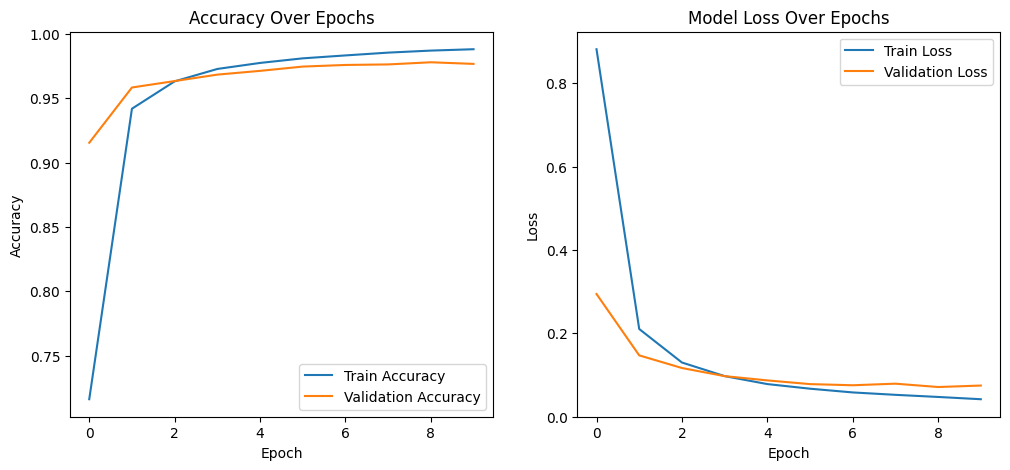

In [41]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy') # blue
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # orange
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

### > notes for my understanding
- this makes sense b/c as the model accuracy increases, the model loss decreases
- as the model is getting more accurate with its interpretations, the loss function is minimized

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


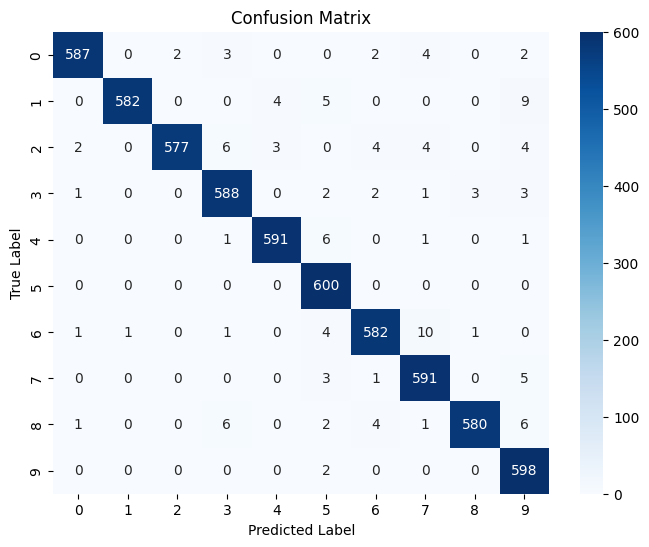

In [42]:
from sklearn.metrics import confusion_matrix

# Predict classes
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()